# SetUp

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import json
from pathlib import Path
import sys
import seaborn as sns
import pandas as pd
import scipy
from IPython.display import display

# import tensorflow_probability as tfp
# tfb = tfp.bijectors
# tfd = tfp.distributions
# tfk = tfp.math.psd_kernels

# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF

import gymnasium as gym

In [2]:
sys.path.insert(0, '../')
from barl import envs
from barl.models.gpflow_gp import GpflowGp
from barl.envs.wrappers import NormalizedEnv

2023-08-28 10:25:30.211136: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 10:25:52.604368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/mnt/beegfs/home/douka/miniconda3/envs/gymnasium_env/lib/python3.8/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


# Load Data

In [3]:
base_path = Path('../')
# gp_lorenz = 'experiments_cache/fit_hyperparams/hyperfit_lorenz_fixed_2023-08-23/18-27-20/seed_0/hyperfit_lorenz_fixed.log'
gp_lorenz = 'experiments_cache/fit_hyperparams/hyperfit_lorenz_noisy_2023-08-24/22-25-10/seed_0/hyperfit_lorenz_noisy.log'
opt_path_lorenz = 'experiments_cache/barl_original_lorenz/barl_lorenz_100/iters_150_noisy_short/seed_0'
gp_pendulum = 'experiments_cache/fit_hyperparams/prefit_pendulum/pendulum_gp.log'
opt_path_pendulum = 'experiments/barl_pendulum_100_2023-08-25/19-06-08/seed_3'

In [4]:
def process_log(data):
    info = {}
    for line in data:
        if 'gp_params' in line:
            gp_param = line.split('-')[-1].split('=')
            index = int(gp_param[0].strip()[-1]) # works only for one digit
            gp_param = gp_param[-1].strip()
            gp_param = eval(gp_param)
            info[index] = gp_param
    return info

def process_info(data):
    info = {}
    if 'gt_paths' in data.keys():
        info['x*'] = np.array(data['gt_paths'][0].x)
        info['y*'] = np.array(data['gt_paths'][0].y)
    if 'x' in data.keys():
        info['train x'] = np.array(data['x'])
        info['train y'] = np.array(data['y'])
    return info

In [5]:
def load_log(path):
    info_path =  base_path / path 
    if info_path.exists():
        print(f'Found path {info_path}')
        with info_path.open('r') as f:
            data = process_log(f.readlines())
        return data
    raise FileNotFoundError()
    
def load_pickle(path):
    info_path = base_path / path / 'info.pkl'
    if info_path.exists():
        print(f'Found path {info_path}')
        with info_path.open('rb') as f:
            data = process_info(pickle.load(f))
        return data
    raise FileNotFoundError()

In [6]:
data_lorenz = load_log(gp_lorenz)
data_lorenz[0]

Found path ../experiments_cache/fit_hyperparams/hyperfit_lorenz_noisy_2023-08-24/22-25-10/seed_0/hyperfit_lorenz_noisy.log


{'ls': [0.8769794814231504,
  3.446964825195763,
  4.653277867192647,
  22.342579016223766,
  103.5385985880879,
  145.89146384417006],
 'alpha': 1.026336044903068,
 'sigma': 0.010000000000000005,
 'n_dimx': 6}

In [7]:
data_pendulum = load_log(gp_pendulum)
data_pendulum

Found path ../experiments_cache/fit_hyperparams/prefit_pendulum/pendulum_gp.log


{0: {'ls': [2.27, 7.73, 138.94],
  'alpha': 0.54,
  'sigma': 0.010000000000000005,
  'n_dimx': 3},
 1: {'ls': [0.84, 288.15, 11.05],
  'alpha': 0.22,
  'sigma': 0.010000000000000005,
  'n_dimx': 3}}

In [8]:
optimal_t_lorenz = load_pickle(opt_path_lorenz)
print(len(optimal_t_lorenz['x*'])) # should be horizon

optimal_t_pendulum = load_pickle(opt_path_pendulum)
print(len(optimal_t_pendulum['x*']))

Found path ../experiments_cache/barl_original_lorenz/barl_lorenz_100/iters_150_noisy_short/seed_0/info.pkl
20
Found path ../experiments/barl_pendulum_100_2023-08-25/19-06-08/seed_3/info.pkl
204


# Squared Exponential Kernel

$$
k_{SE}(x_i, x_j) = \sigma^2 exp(- \frac{d(x_i,x_j)^2}{2l^2})
$$
where l = length_scale <br>
$\sigma^2$ = variance = sigma <br>
alpha = mean

In [9]:
class SqrExpKernel():
    def __init__(self, data):
        self.input_dim = data['n_dimx']
        self.length_scale = data['ls']
        self.alpha = data['alpha']
        self.sigma = data['sigma']
        
        self.kernel = (self.alpha**2) * RBF(self.length_scale)
        
    
    def __call__(self, xi, xj, dim=None):
        assert(xi.shape[1] == xj.shape[1])
        if dim!=None:
            kernel = (self.alpha)**2 * RBF(self.length_scale[dim])
        else:
            kernel = self.kernel
        return kernel(xi, xj)
#         sq_norm = -0.5 *  scipy.spatial.distance.cdist(xi, xj, 'sqeuclidean')
#         ls = kernel.length_scale[dim] if dim else kernel.length_scale
#         sq_norm = np.divide(sq_norm, np.power(ls, 2))
#         return np.exp(sq_norm)
    def __str__(self):
        return str(kernel.kernel)

## Plot gaussians

In [10]:
kernel = SqrExpKernel(data_lorenz[0])
print(kernel)

0.981**2 * RBF(length_scale=[0.878, 3.4, 4.62, 21.8, 95.7, 134])


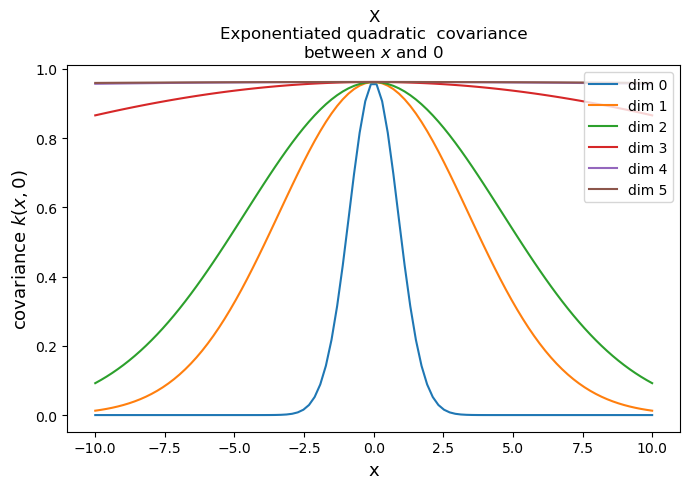

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
xlim = (-10, 10)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
# print(X.shape)
# X = test_X

zero = np.array([[0]])
# zero = np.zeros((1, 6))
# print(zero)
# Σ0 = exponentiated_quadratic(kernel, X, zero, dim=0)
for dim in range(kernel.input_dim):
    Σ0 = kernel(X, zero, dim)
    # Make the plots
    ax.plot(X[:,0], Σ0[:,0], label=f'dim {dim}')
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('covariance $k(x,0)$', fontsize=13)
ax.set_title((
    'X\nExponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax.set_yscale('log')
# ax.set_xlim(*xlim)
ax.legend(loc=1)

fig.tight_layout()
plt.show()

2.43**2 * RBF(length_scale=[0.603, 1.84, 2.84, 12.6, 50.2, 73])


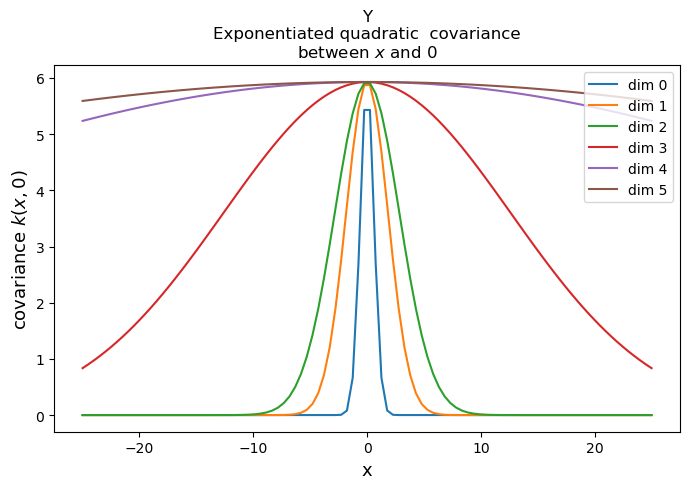

In [12]:
kernel = SqrExpKernel(data_lorenz[1])
print(kernel)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
xlim = (-25, 25)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)

zero = np.array([[0]])
for dim in range(kernel.input_dim):
    Σ0 = kernel(X, zero, dim)
    # Make the plots
    ax.plot(X[:,0], Σ0[:,0], label=f'dim {dim}')
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('covariance $k(x,0)$', fontsize=13)
ax.set_title((
    'Y\nExponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax.set_yscale('log')
# ax.set_xlim(*xlim)
ax.legend(loc=1)

fig.tight_layout()
plt.show()

2.63**2 * RBF(length_scale=[0.595, 1.95, 2.84, 13.6, 51.5, 68.6])


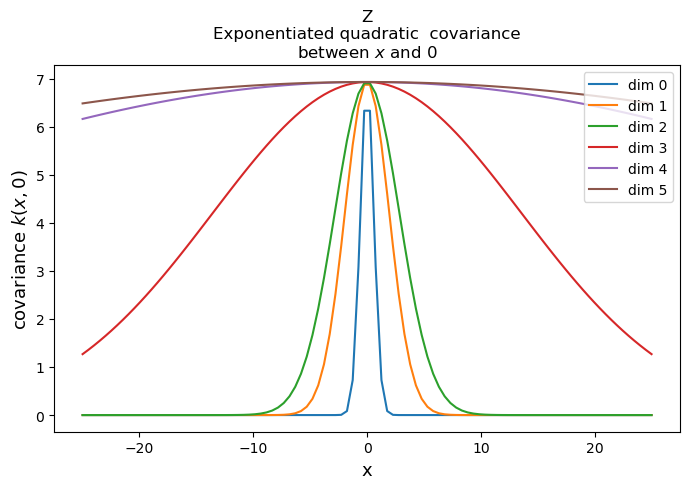

In [13]:
kernel = SqrExpKernel(data_lorenz[2])
print(kernel)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
xlim = (-25, 25)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)

zero = np.array([[0]])
for dim in range(kernel.input_dim):
    Σ0 = kernel(X, zero, dim)
    # Make the plots
    ax.plot(X[:,0], Σ0[:,0], label=f'dim {dim}')
ax.set_xlabel('x', fontsize=13)
ax.set_ylabel('covariance $k(x,0)$', fontsize=13)
ax.set_title((
    'Z\nExponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax.set_yscale('log')
# ax.set_xlim(*xlim)
ax.legend(loc=1)

fig.tight_layout()
plt.show()

## Plot Prior Trajectories

In [14]:
state_0 = 1 + np.random.normal(loc=0, scale=0, size=3)
action_0 = np.zeros(3)

init_cond = np.concatenate((state_0, action_0))
init_cond

array([1., 1., 1., 0., 0., 0.])

In [15]:
# Z = squared_exponential(kernel.length_scale, init_cond, init_cond)
# print(Z.shape)

# ys = np.random.multivariate_normal(mean=np.zeros(init_cond.shape[0]), cov=Z, size=5)
# print(ys)

# time = np.zeros(5)
# x1 = init_cond[:, 0]+ ys
# print(x1)

def sample_prior(kernel, init_cond, dimention, n_samples=5, horizon=40, seed=0):
    np.random.seed(seed)
    x = []

    x0 = np.full(n_samples, init_cond[dimention])
    x.append(x0)

    for i in range(horizon-1):
        xi = x[i]
        xyza = np.array([init_cond.copy()]*n_samples)
        xyza[:, dimention] = xi

        cov = kernel(xyza, xyza)
        mean = np.zeros(n_samples)

        delta_x = np.random.multivariate_normal(mean=mean, cov=cov, size=n_samples)[:, 0]
        x_next = xi + delta_x
        x.append(x_next)

    x = np.array(x)
    return x

Kernel: 0.981**2 * RBF(length_scale=[0.878, 3.4, 4.62, 21.8, 95.7, 134])
(40, 5)


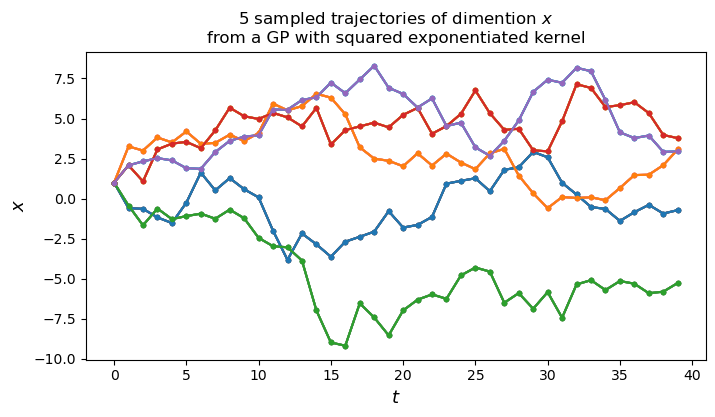

In [16]:
kernel = SqrExpKernel(data_lorenz[0])
print('Kernel:', kernel)

x = sample_prior(kernel, init_cond, dimention=0, seed=1)
print(x.shape)

horizon = x.shape[0]
n_samples = x.shape[1]
time = np.array([np.arange(horizon)]*n_samples).T
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(time, x, linestyle='-', marker='o', markersize=3)
plt.xlabel('$t$', fontsize=13)
plt.ylabel('$x$', fontsize=13)
plt.title((
    f'{n_samples} sampled trajectories of dimention $x$\n'
    'from a GP with squared exponentiated kernel'))
# plt.ylim((0.9, 1.2))
plt.show()

Kernel: 2.43**2 * RBF(length_scale=[0.603, 1.84, 2.84, 12.6, 50.2, 73])


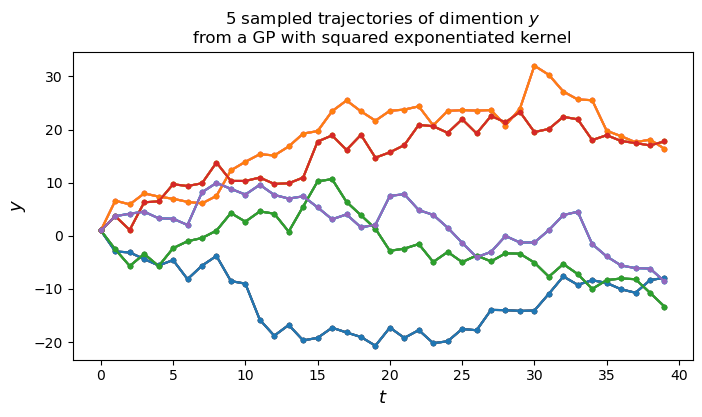

In [17]:
kernel = SqrExpKernel(data_lorenz[1])
print('Kernel:', kernel)

y = sample_prior(kernel, init_cond, dimention=1, seed=1)

horizon = y.shape[0]
n_samples = y.shape[1]
time = np.array([np.arange(horizon)]*n_samples).T

plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(time, y, linestyle='-', marker='o', markersize=3)
plt.xlabel('$t$', fontsize=13)
plt.ylabel('$y$', fontsize=13)
plt.title((
    f'{n_samples} sampled trajectories of dimention $y$\n'
    'from a GP with squared exponentiated kernel'))
# plt.ylim((0.9, 1.2))
plt.show()

Kernel: 2.63**2 * RBF(length_scale=[0.595, 1.95, 2.84, 13.6, 51.5, 68.6])


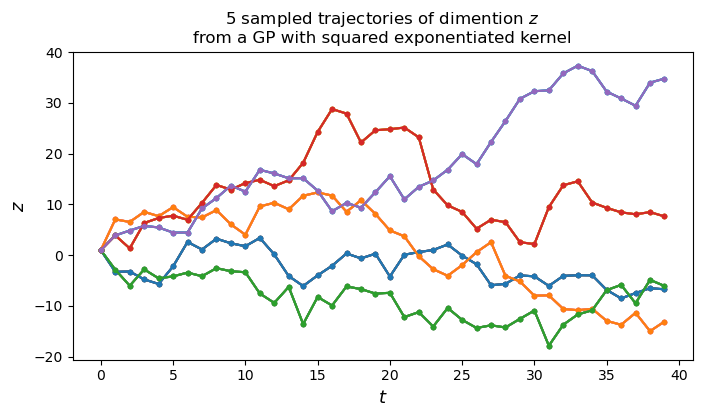

In [18]:
kernel = SqrExpKernel(data_lorenz[2])
print('Kernel:', kernel)

z = sample_prior(kernel, init_cond, dimention=2, seed=1)

horizon = z.shape[0]
n_samples = z.shape[1]
time = np.array([np.arange(horizon)]*n_samples).T

plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(time, z, linestyle='-', marker='o', markersize=3)
plt.xlabel('$t$', fontsize=13)
plt.ylabel('$z$', fontsize=13)
plt.title((
    f'{n_samples} sampled trajectories of dimention $z$\n'
    'from a GP with squared exponentiated kernel'))
# plt.ylim((0.8, 1.4))
plt.show()

# Gpflow GP

In [9]:
default_save_path = 'results/GP_plots/'
save_path = default_save_path

## Util

In [10]:
def GP_prior(process, input_x, n_samples=1, seed=None):
    np.random.seed(seed)
    return process.sample_prior(input_x, n_samples)
#     mu, cov = process.get_prior_mu_cov(input_x, full_cov=True)
#     return process.get_normal_samples(mu, cov, n_samples, full_cov=True)
def GP_posterior(process, input_x, n_samples=1, seed=None):
    np.random.seed(seed)
    return process.sample_post(input_x, n_samples)

In [11]:
def get_output_y(data, dim_y):
    max_dim_y = data['train y'].shape[1]
    assert( dim_y < max_dim_y ), \
        f"output y has only {data['train y'].shape[1]} dimentions, use dim_y < {max_dim_y}"
    new_data = {'x': data['train x']}
    new_data['y'] = data['train y'][:, dim_y]
    return new_data

In [86]:
def plot_optimal_t(sample_type:str, processes:list, names:list, env_name:str):
    assert(sample_type in ('prior', 'posterior')), "sample type should be one of: ('prior', 'posterior')"
    for dim, process in enumerate(processes):
        plt.figure(figsize=(8, 4))

        # Get groundtruth trajectories of env 
        # (s,a) -> ds*
        plt.plot(time, delta_t_star[:, dim], linestyle='-', marker='o', markersize=2, label=r'optimal $\tau^*$ $\Delta_t$')

        # Get GP prediction of (s,a) -> ds'
        delta_t_gp = []
        for h in range(horizon):
            xi = x[h]
            if sample_type == 'posterior': delta = GP_posterior(process, xi, seed=seed)[0]
            else: delta = GP_prior(process, xi, seed=seed)[0]
            delta_t_gp.append(delta)
        #     yi = xi[dim] + delta
        #     transition = [xi[dim], yi]

        plt.plot(time, delta_t_gp, marker='o', markersize=2, label=f'GP {sample_type} $\Delta_t$')

        plt.xlabel('$t$', fontsize=13)
        plt.ylabel(rf'$\Delta_{names[dim]}$', fontsize=13)
        plt.title(rf'Comparing $\tau^*$ groundtruth dynamics with GP {sample_type} on {env_name}')
        plt.legend(loc=1)
        plt.savefig(f'{save_path}{env_name.lower()}/{sample_type}_opt_trajectory_{env_name}_{names[dim]}.png', bbox_inches='tight')
        plt.show()

In [87]:
def plot_no_control(sample_type:str, processes:list, names:list, env_name:str):
    assert(sample_type in ('prior', 'posterior')), "sample type should be one of: ('prior', 'posterior')"
    for dim, process in enumerate(processes):
        plt.figure(figsize=(8, 4))

        # Get groundtruth trajectories of env 
        # (s,a) -> ds*
        plt.plot(time, deltas[:horizon, dim], linestyle='-', marker='o', markersize=2, label=r'uncontroled $\tau$ $\Delta_t$')

        # Get GP prediction of (s,a) -> ds'
        delta_t_gp = []
        for h in range(horizon):
            xi = dynamics[h]
            if sample_type == 'posterior': delta = GP_posterior(process, xi, seed=seed)[0]
            else: delta = GP_prior(process, xi, seed=seed)[0]
            delta_t_gp.append(delta)

        plt.plot(time, delta_t_gp, marker='o', markersize=2, label=f'GP {sample_type} $\Delta_t$')

        plt.xlabel('$t$', fontsize=13)
        plt.ylabel(rf'$\Delta_{names[dim]}$', fontsize=13)
        plt.title(f'Comparing uncontroled groundtruth dynamics with GP {sample_type} on {env_name}')
        plt.legend(loc=1)
        plt.savefig(f'{save_path}{env_name.lower()}/{sample_type}_uncontroled_trajectory_{env_name}_{names[dim]}.png', bbox_inches='tight')
        plt.show()

In [88]:
def plot_random_control(sample_type:str, processes:list, names:list, env_name:str):
    assert(sample_type in ('prior', 'posterior')), "sample type should be one of: ('prior', 'posterior')"
    for dim, process in enumerate(processes):
        plt.figure(figsize=(8, 4))

        # Get groundtruth trajectories of env 
        # (s,a) -> ds*
        plt.plot(time, r_deltas[:horizon, dim], linestyle='-', marker='o', markersize=2, label=r'random control $\tau$ $\Delta_t$')

        # Get GP prediction of (s,a) -> ds'
        delta_t_gp = []
        for h in range(horizon):
            xi = r_dynamics[h]
            if sample_type == 'posterior': delta = GP_posterior(process, xi, seed=seed)[0]
            else: delta = GP_prior(process, xi, seed=seed)[0]
            delta_t_gp.append(delta)
#             print(f"true={r_deltas[h, dim]} gp={delta}")

        plt.plot(time, delta_t_gp, marker='o', markersize=2, label=f'GP {sample_type} $\Delta_t$')

        plt.xlabel('$t$', fontsize=13)
        plt.ylabel(rf'$\Delta_{names[dim]}$', fontsize=13)
        plt.title(f'Comparing random control groundtruth dynamics with GP {sample_type} on {env_name}')
        plt.legend(loc=1)
        plt.savefig(f'{save_path}{env_name.lower()}/{sample_type}_random_trajectory_{env_name}_{names[dim]}.png', bbox_inches='tight')
        plt.show()

## Lorenz

In [89]:
# state_0 = 1 + np.random.normal(loc=0, scale=0, size=3)
action_0 = np.zeros(3)

# init_cond = np.concatenate((state_0, action_0))
# init_cond

In [90]:
data_lorenz[0]

{'ls': [0.8769794814231504,
  3.446964825195763,
  4.653277867192647,
  22.342579016223766,
  103.5385985880879,
  145.89146384417006],
 'alpha': 1.026336044903068,
 'sigma': 0.010000000000000005,
 'n_dimx': 6}

In [91]:
process_x = GpflowGp(params=data_lorenz[0], data=get_output_y(optimal_t_lorenz, 0))
process_y = GpflowGp(params=data_lorenz[1], data=get_output_y(optimal_t_lorenz, 1))
process_z = GpflowGp(params=data_lorenz[2], data=get_output_y(optimal_t_lorenz, 2))
process_x.params

Namespace(alpha=1.026336044903068, dumper=None, fixed_mean_func=True, fixed_noise=True, kernel=<function kern_exp_quad_ard at 0x7fa5456b3430>, kernel_str='rbf', ls=[0.8769794814231504, 3.446964825195763, 4.653277867192647, 22.342579016223766, 103.5385985880879, 145.89146384417006], mean_func_c=0.0, n_dimx=6, name='GpflowGp', opt_max_iter=1000, print_fit_hypers=False, sigma=0.010000000000000005, use_ard=True, verbose=True)

In [92]:
# print(init_cond)
# mu, cov = process_x.get_prior_mu_cov([init_cond], full_cov=True)
# print(mu)
# print(cov)
# process_x.get_normal_samples(mu, cov, 3, full_cov=True)

In [93]:
# print(GP_prior(process_x, [2.,2.,12.,7.,10.,0.], seed=0))
# print(GP_prior(process_y, init_cond))
# print(GP_prior(process_z, init_cond))

In [94]:
"""
Optimal trajectory
"""
x = optimal_t_lorenz['x*']

horizon = len(x)

delta_t_star = []
for h in range(horizon-1):
    xa = x[h]
    xb = x[h+1]
    delta = xb - xa
    delta_t_star.append(delta)
delta_t_star = np.array(delta_t_star)
delta_t_star.shape

(19, 6)

In [95]:
"""
Uncontroled groundtruth dynamics
"""
env = NormalizedEnv(gym.make('lorenz-v0'))
obs, _ = env.reset() #initial condition
print(obs)
    
dynamics, deltas = [], []
dynamics.append(np.concatenate([obs, action_0]))
for h in range(2_000):
    obs, reward, term, trunc, info = env.step(action_0)
    x = np.concatenate([obs, action_0])
    dynamics.append(x)
    deltas.append(info['delta_obs'])
#     if term or trunc: break

dynamics = np.array(dynamics)
deltas = np.array(deltas)

[-0.1717248  -0.17091615  0.54175138]


In [96]:
"""
Random control groundthruth dynamics
"""
env = NormalizedEnv(gym.make('lorenz-v0'))
print(env.init_cond_scale)
obs, _ = env.reset()
print(obs)

r_dynamics, r_deltas = [], []

action = env.action_space.sample()
r_dynamics.append(np.concatenate([obs, action]))
for h in range(2_000):
    obs, reward, term, trunc, info = env.step(action)
    x = np.concatenate([obs, action])
    r_dynamics.append(x)
    r_deltas.append(info['delta_obs'])
    action = env.action_space.sample()
#     if term or trunc: break

r_dynamics = np.array(r_dynamics)
r_deltas = np.array(r_deltas)

0.1
[-0.16981871 -0.16652413  0.53980194]


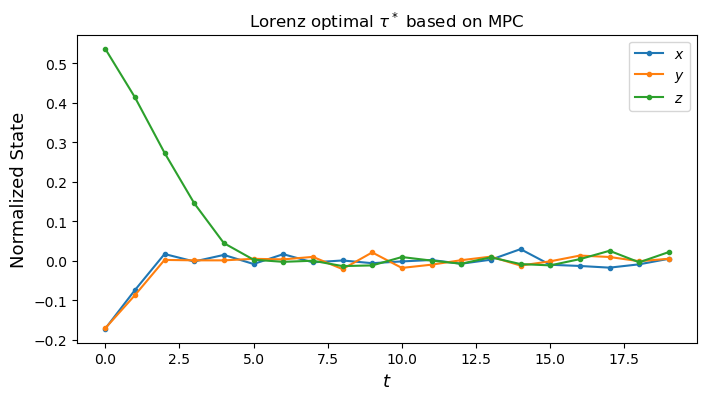

In [97]:
# Get groundtruth trajectories of Lorenz, run env 
# (s,a) -> s*
x = optimal_t_lorenz['x*']
# print(x[:2])
# print()

seed = None
horizon = len(x)
time = np.arange(horizon)


plt.figure(figsize=(8, 4))

plt.plot(time, x[:horizon,0], linestyle='-', marker='o', markersize=3, label=r'$x$')
plt.plot(time, x[:horizon,1], linestyle='-', marker='o', markersize=3, label=r'$y$')
plt.plot(time, x[:horizon,2], linestyle='-', marker='o', markersize=3, label=r'$z$')
plt.xlabel('$t$', fontsize=13)
plt.ylabel('Normalized State', fontsize=13)


plt.title(rf'Lorenz optimal $\tau^*$ based on MPC')
plt.legend(loc=1)
plt.savefig(f'{save_path}lorenz/MPC_opt_trajectory_lorenz.png', bbox_inches='tight')
plt.show()

[-0.17278941 -0.16629655  0.53938025]
1999
(2000, 3)


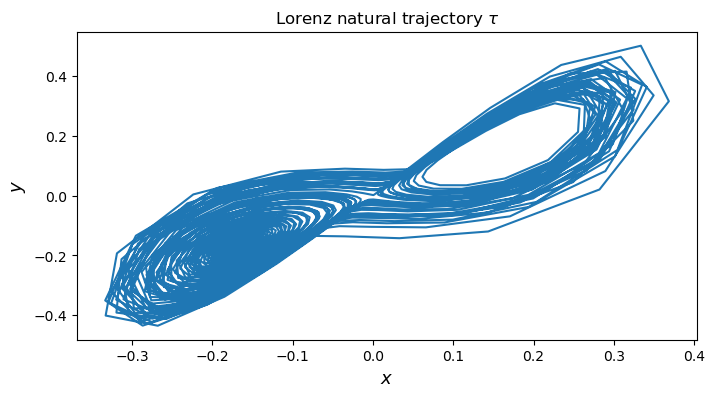

In [98]:
"""
Uncontroled groundtruth dynamics
"""
env = NormalizedEnv(gym.make('lorenz-v0'))
obs, _ = env.reset() #initial condition
print(obs)
    
# dynamics, deltas = [], []
# dynamics.append(np.concatenate([obs, action_0]))
butterfly = []
for h in range(2_000):
    obs, reward, term, trunc, info = env.step(action_0)
    butterfly.append(obs)
#     x = np.concatenate([obs, action_0])
#     dynamics.append(x)
#     deltas.append(info['delta_obs'])
#     if term or trunc: break
print(h)
butterfly = np.array(butterfly)
print(butterfly.shape)

fig, ax = plt.subplots(figsize=(8, 4))
# time = np.arange(len(butterfly))
plt.plot(butterfly[:,0], butterfly[:,1], linestyle='-')#, marker='o', markersize=3)
# plot=plt.scatter(butterfly[:,0], butterfly[:,1], c=time)
# plt.colorbar(plot, ax=ax, label='time horizon')
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y$', fontsize=13)

plt.title(rf'Lorenz natural trajectory $\tau$')

plt.savefig(f'{save_path}lorenz/uncontroled_trajectory_lorenz.png', bbox_inches='tight')
plt.show()

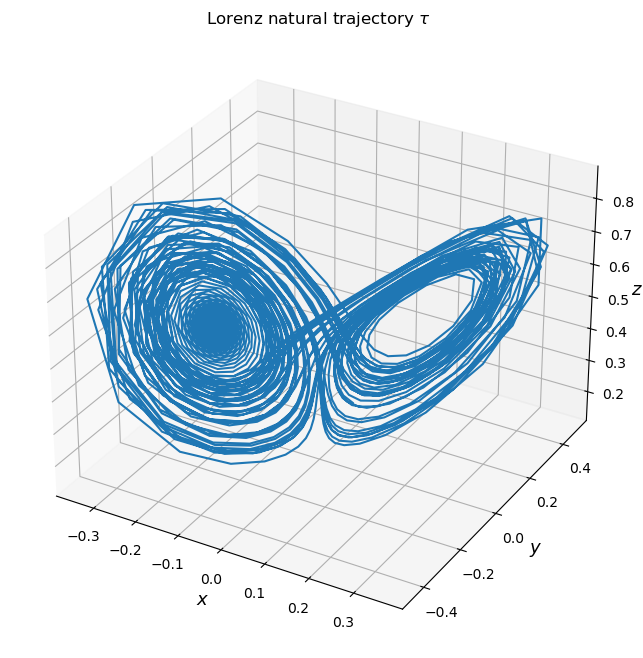

In [76]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1, projection='3d')

plt.plot(butterfly[:,0], butterfly[:,1], butterfly[:,2], linestyle='-')#, marker='o', markersize=3)

# time = np.arange(len(butterfly))
# plot=plt.scatter(butterfly[:,0], butterfly[:,1], butterfly[:,2], c=time)
# plt.colorbar(plot, ax=ax, label='time horizon')

# ax.set_xlabel(r'$x$')
# ax.set_ylabel(r'$y$')
# ax.set_zlabel(r'$z$')

ax.set_xlabel('$x$', fontsize=13)
ax.set_ylabel('$y$', fontsize=13)
ax.set_zlabel('$z$', fontsize=13, labelpad=-1)

plt.title(rf'Lorenz natural trajectory $\tau$')

plt.savefig(f'{save_path}lorenz/uncontroled_trajectory3D_lorenz.png', bbox_inches='tight')
plt.show()
fig.show()

### Prior

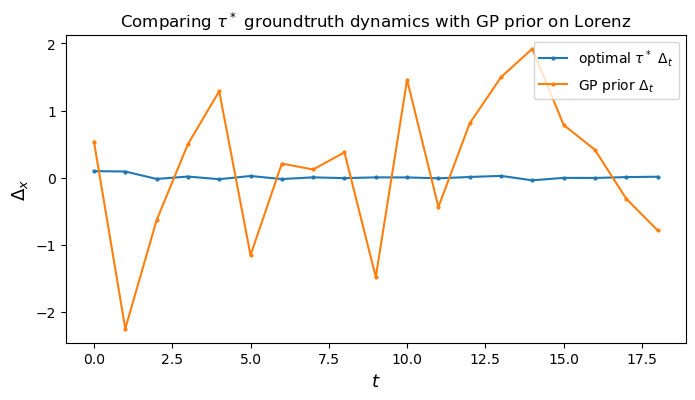

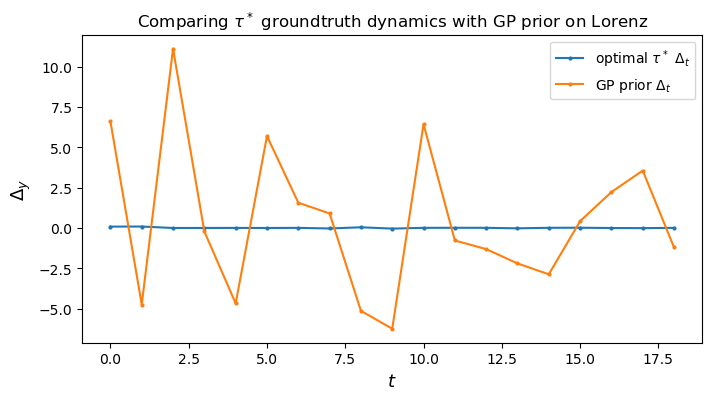

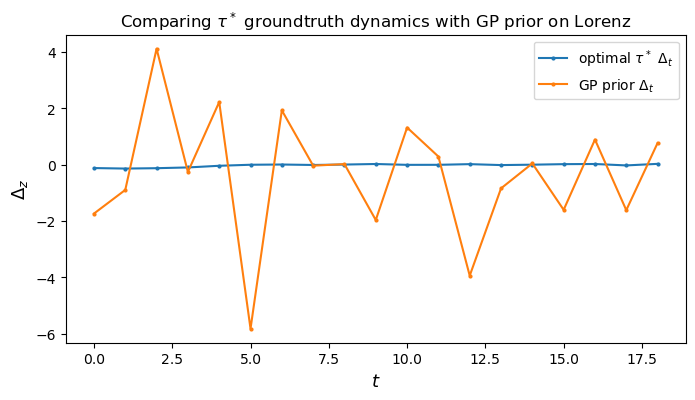

In [99]:
"""
dynamics: optimal control next observations
deltas: optimal control obs deltas
"""
x = optimal_t_lorenz['x*']

seed = None
horizon = 20-1
time = np.arange(horizon)
        
plot_optimal_t('prior', [process_x, process_y, process_z], ['x', 'y', 'z'], 'Lorenz')

In [100]:
# # Get groundtruth trajectories of Lorenz, run env 
# # (s,a) -> s*
# x = optimal_t_lorenz['x*']
# # print(x[:2])
# # print()

# seed = None
# horizon = 200
# time = np.arange(horizon)

# dim = 0


# plt.figure(figsize=(8, 4))

# plt.plot(time, x[:horizon,0], linestyle='-', marker='o', markersize=3, label=r'optimal $\tau^*$')
# plt.xlabel('$t$', fontsize=13)
# plt.ylabel('$x$', fontsize=13)


# # Get GP prediction of (s,a) -> s'
# delta_t = []
# for h in range(horizon-1):
#     xi = x[h]
#     delta = GP_prior(process_x, xi, seed=seed)[0]
#     delta_t.append(delta)
#     yi = xi[dim] + delta
#     transition = [xi[dim], yi]
    
#     plt.plot(time[h:h+2], transition, c='#ff7f0e')

# plt.plot([],[], c='#ff7f0e', label='GP prior prediction')

# plt.title(f'Comparing groundtruth dynamics with GP prior on Lorenz')
# plt.legend(loc=1)
# plt.show()

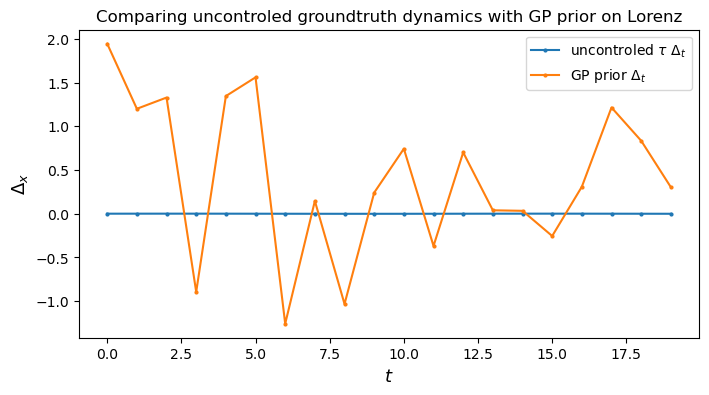

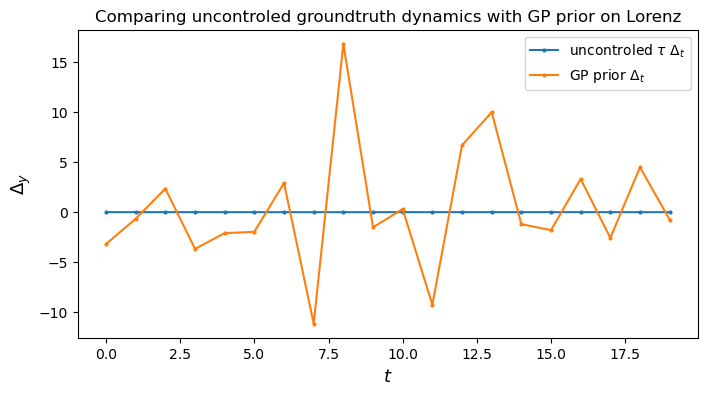

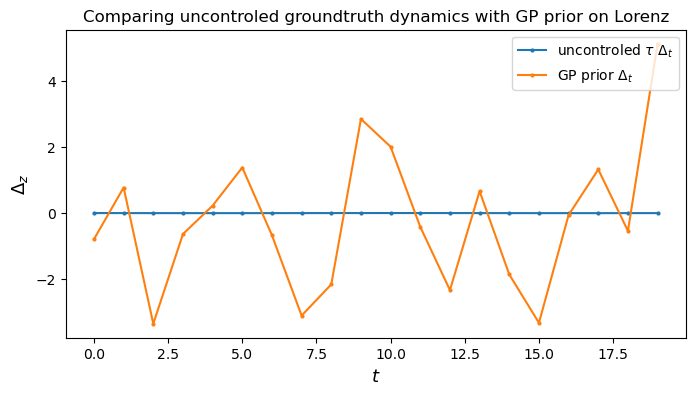

In [101]:
"""
dynamics: no control next observations
deltas: no control obs deltas
"""
x = optimal_t_lorenz['x*']


seed = None
horizon = 20
time = np.arange(horizon)

plot_no_control('prior', [process_x, process_y, process_z], ['x', 'y', 'z'], 'Lorenz')

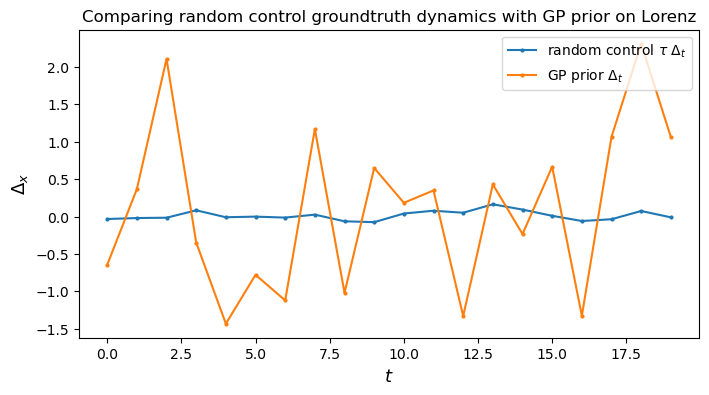

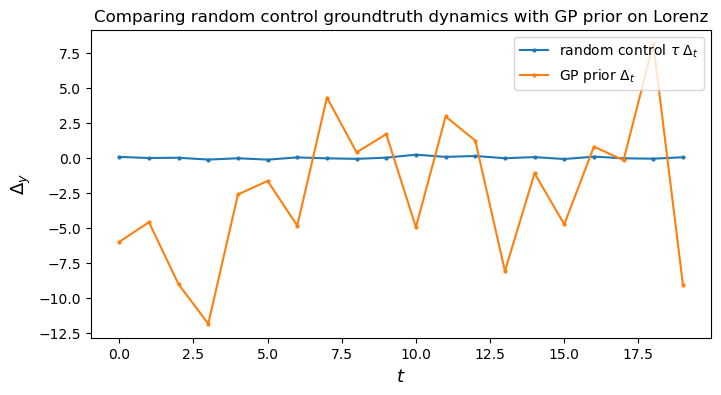

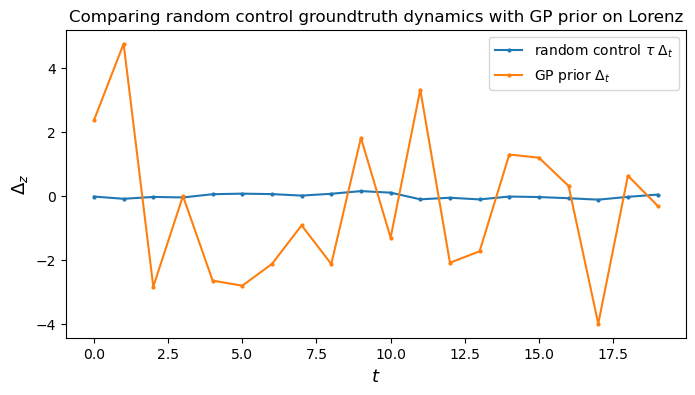

In [102]:
"""
r_dynamics: random control next observations
r_deltas: random control obs deltas
"""
seed = None
horizon = 20
time = np.arange(horizon)

plot_random_control('prior', [process_x, process_y, process_z], ['x', 'y', 'z'], 'Lorenz')

### Posterior

In [103]:
display(process_z.model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,False,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,6.7406625236393385
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(6,)",float64,"[0.59211435, 1.94516337, 2.82363631..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.00010000000000000011


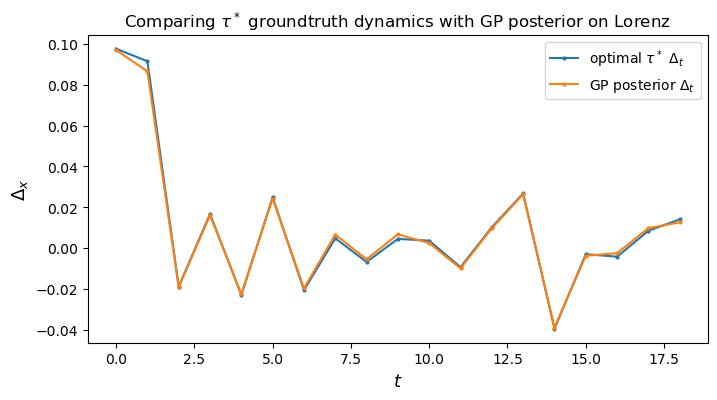

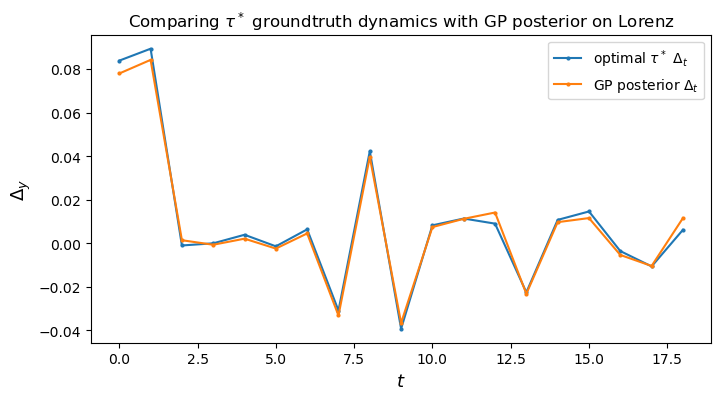

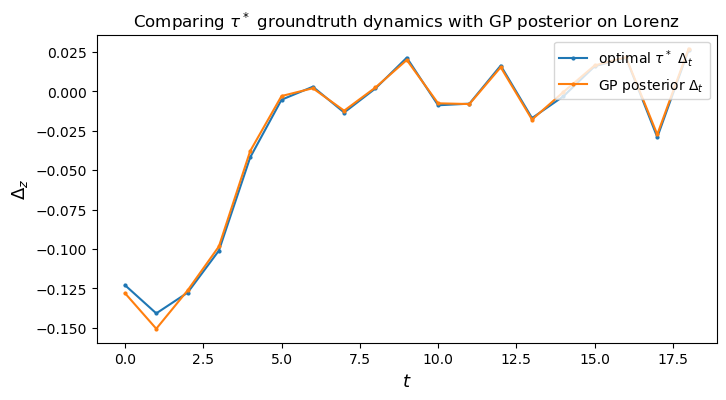

In [104]:
"""
dynamics: optimal control next observations
deltas: optimal control obs deltas
"""
x = optimal_t_lorenz['x*']

seed = None
horizon = len(x)-1
time = np.arange(horizon)

plot_optimal_t('posterior', [process_x, process_y, process_z], ['x', 'y', 'z'], 'Lorenz')

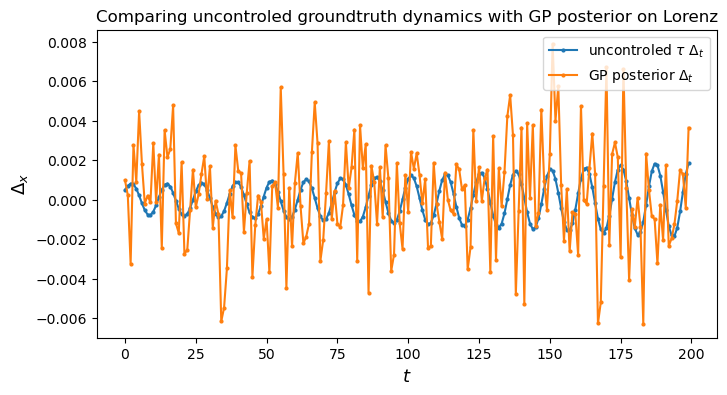

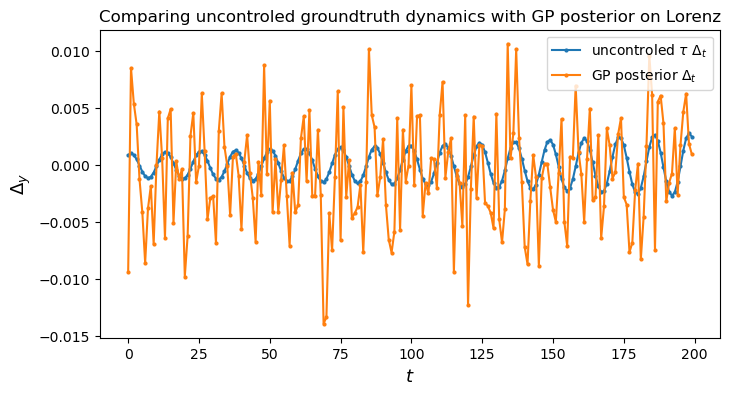

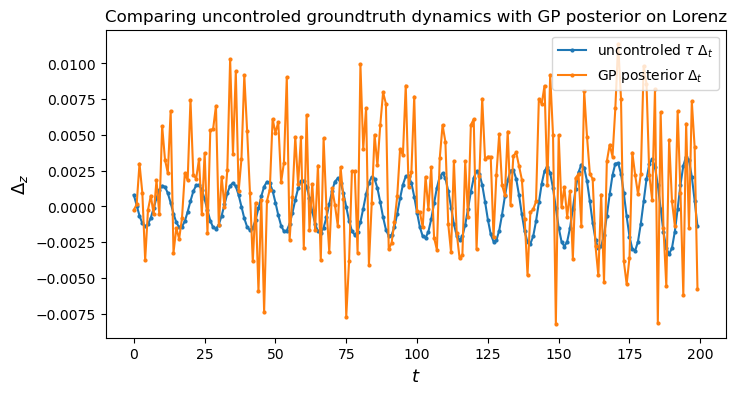

In [105]:
"""
dynamics: no control next observations
deltas: no control obs deltas
"""
seed = None
horizon = 200
time = np.arange(horizon)

plot_no_control('posterior', [process_x, process_y, process_z], ['x', 'y', 'z'], 'Lorenz')

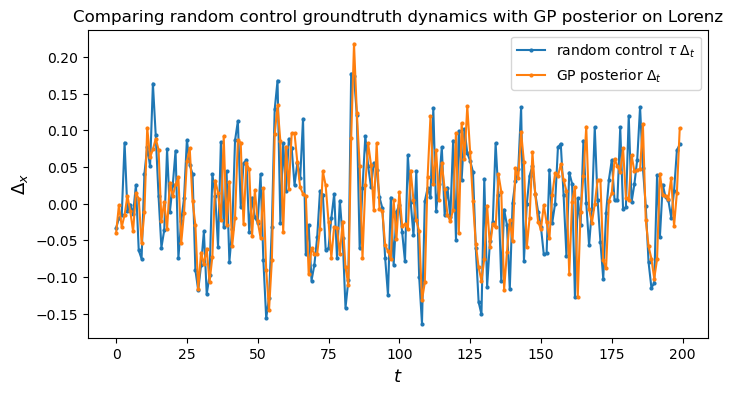

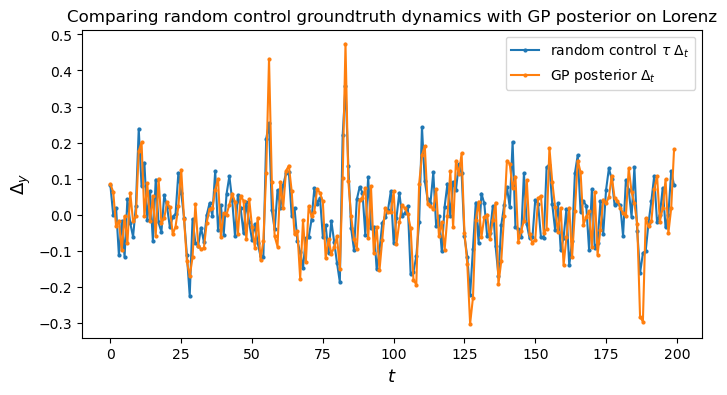

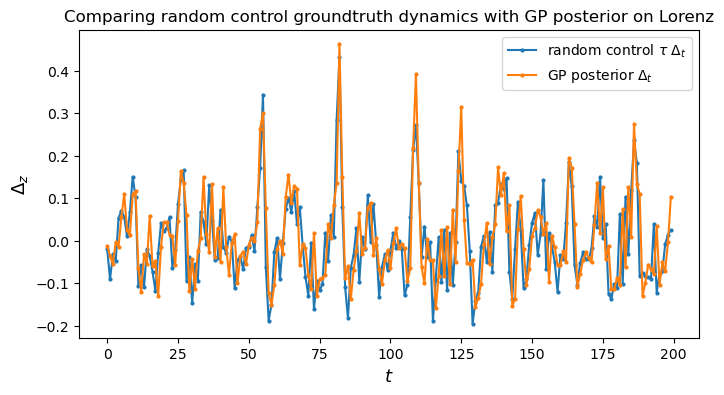

In [106]:
"""
r_dynamics: random control next observations
r_deltas: random control obs deltas
"""
seed = None
horizon = 200
time = np.arange(horizon)

plot_random_control('posterior', [process_x, process_y, process_z], ['x', 'y', 'z'], 'Lorenz')

## Pendulum

In [107]:
# state_0 = 1 + np.random.normal(loc=0, scale=0, size=2)
action_0 = np.zeros(1)

# init_cond = np.concatenate((state_0, action_0))
# init_cond

In [108]:
data_pendulum[0]

{'ls': [2.27, 7.73, 138.94],
 'alpha': 0.54,
 'sigma': 0.010000000000000005,
 'n_dimx': 3}

In [109]:
process_x = GpflowGp(params=data_pendulum[0], data=get_output_y(optimal_t_pendulum, 0))
process_y = GpflowGp(params=data_pendulum[1], data=get_output_y(optimal_t_pendulum, 1))
process_x.params

Namespace(alpha=0.54, dumper=None, fixed_mean_func=True, fixed_noise=True, kernel=<function kern_exp_quad_ard at 0x7fa5456b3430>, kernel_str='rbf', ls=[2.27, 7.73, 138.94], mean_func_c=0.0, n_dimx=3, name='GpflowGp', opt_max_iter=1000, print_fit_hypers=False, sigma=0.010000000000000005, use_ard=True, verbose=True)

In [110]:
"""
Optimal trajectory
"""
horizon = 200

x = optimal_t_pendulum['x*']

delta_t_star = []
for h in range(horizon):
    xa = x[h]
    xb = x[h+1]
    delta = xb - xa
    delta_t_star.append(delta)
delta_t_star = np.array(delta_t_star)
delta_t_star.shape

(200, 3)

In [111]:
"""
Uncontroled groundtruth dynamics
"""
env = NormalizedEnv(gym.make('bacpendulum-v0'))
obs, _ = env.reset()
    
dynamics, deltas = [], []
dynamics.append(np.concatenate([obs, action_0]))
for h in range(env.horizon):
    obs, reward, term, trunc, info = env.step(action_0)
    x = np.concatenate([obs, action_0])
    dynamics.append(x)
    deltas.append(info['delta_obs'])
    if term or trunc: break

dynamics = np.array(dynamics)
deltas = np.array(deltas)

In [112]:
"""
Random control groundthruth dynamics
"""
env = NormalizedEnv(gym.make('bacpendulum-v0'))
obs, _ = env.reset()

r_dynamics, r_deltas = [], []

# action = env.action_space.sample()
# r_dynamics.append(np.concatenate([obs, action]))
for h in range(env.horizon):
    action = env.action_space.sample()
    x = np.concatenate([obs, action])
    r_dynamics.append(x)
    obs, reward, term, trunc, info = env.step(action)
    r_deltas.append(info['delta_obs'])
#     print(f"{x=}, {info['delta_obs']=}")
    if term or trunc: break

r_dynamics = np.array(r_dynamics)
r_deltas = np.array(r_deltas)
print(r_dynamics.shape)
print(r_deltas.shape)

(200, 3)
(200, 2)


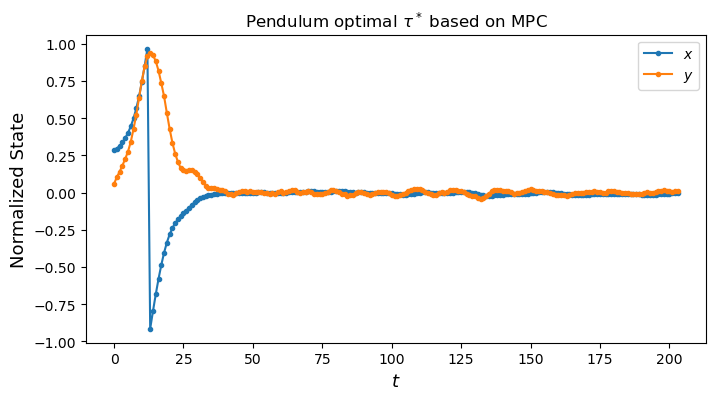

In [113]:
x = optimal_t_pendulum['x*']

seed = None
horizon = len(x)
time = np.arange(horizon)


plt.figure(figsize=(8, 4))

plt.plot(time, x[:horizon,0], linestyle='-', marker='o', markersize=3, label=r'$x$')
plt.plot(time, x[:horizon,1], linestyle='-', marker='o', markersize=3, label=r'$y$')
plt.xlabel('$t$', fontsize=13)
plt.ylabel('Normalized State', fontsize=13)


plt.title(rf'Pendulum optimal $\tau^*$ based on MPC')
plt.legend(loc=1)
plt.savefig(f'{save_path}pendulum/MPC_opt_trajectory_pendulum.png', bbox_inches='tight')
plt.show()

[0.07427746 0.90092739]
1999
(2000, 3)


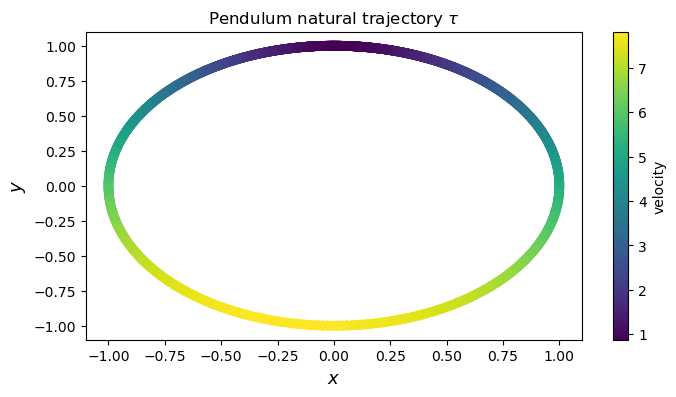

In [114]:
"""
Uncontroled groundtruth dynamics
"""
seed=1
env = gym.make('bacpendulum-v0')
obs, _ = env.reset(seed=seed) #initial condition
print(obs)

pendulum = []
for h in range(2_000):
    obs, reward, term, trunc, info = env.step(action_0)
    x = np.cos(obs[0]) # np.cos(0)=1
    y = np.sin(obs[0]) # np.sin(0)=0
    pendulum.append([x,y, obs[1]])
print(h)
pendulum = np.array(pendulum)
print(pendulum.shape)

fig, ax = plt.subplots(figsize=(8, 4))
# time = np.arange(len(pendulum))
# plt.plot(pendulum[:,1], pendulum[:,0], linestyle='-')#, marker='o', markersize=1)
plot=plt.scatter(pendulum[:,1], pendulum[:,0], c=pendulum[:,2])

plt.colorbar(plot, ax=ax, label='velocity')
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y$', fontsize=13)


plt.title(rf'Pendulum natural trajectory $\tau$')
plt.savefig(f'{save_path}pendulum/uncontroled_trajectory_pendulum.png', bbox_inches='tight')
plt.show()

### Prior

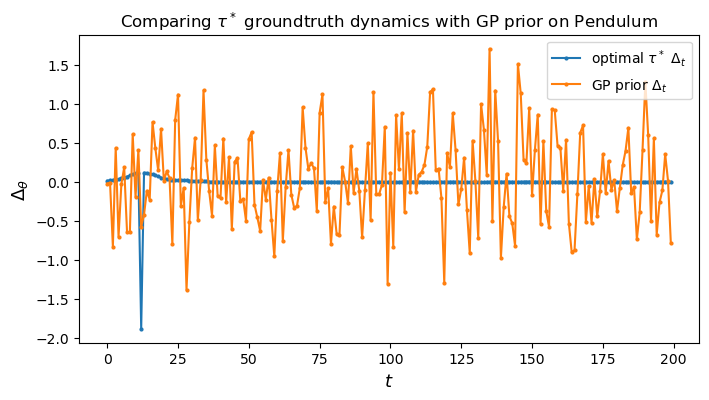

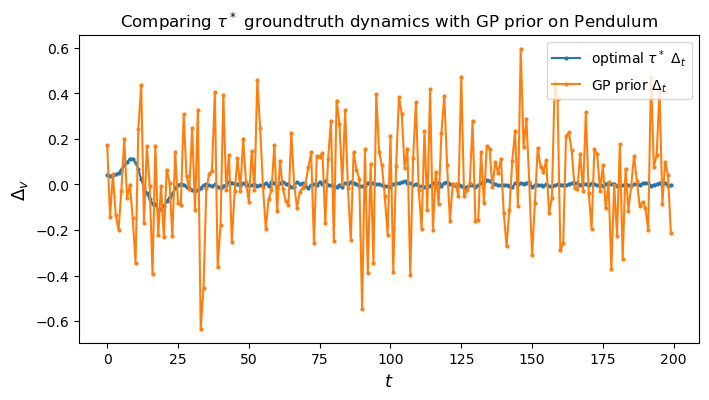

In [115]:
"""
dynamics: optimal control next observations theta & velocity
deltas: optimal control obs theta & velocity deltas
"""
x = optimal_t_pendulum['x*']

seed = None
horizon = 200
time = np.arange(horizon)

plot_optimal_t('prior', [process_x, process_y], [r'\theta', 'v'], 'Pendulum')

In [116]:
# x = optimal_t_pendulum['x*']

# start = 9
# seed = None
# horizon = 200
# time = np.arange(horizon)

# dim = 0
# plt.figure(figsize=(8, 4))

# # Get groundtruth trajectories of Pendulum, run env 
# # (s,a) -> ds*
# plt.plot(time[start:], delta_t_star[start:horizon, 0], linestyle='-', marker='o', markersize=2, label=r'optimal $\tau^*$ $\Delta_t$')

# # Get GP prediction of (s,a) -> ds'
# delta_t_gp = []
# for h in range(horizon):
#     xi = x[h]
#     delta = GP_prior(process_x, xi, seed=seed)[0]
#     delta_t_gp.append(delta)
    
# # plt.plot(time[start:], delta_t_gp[start:], marker='o', markersize=2, label='GP prior $\Delta_t$')

# plt.xlabel('$t$', fontsize=13)
# plt.ylabel('$\Delta_x$', fontsize=13)
# plt.title(f'Comparing groundtruth dynamics with GP prior on Pendulum')
# plt.legend(loc=1)
# plt.show()

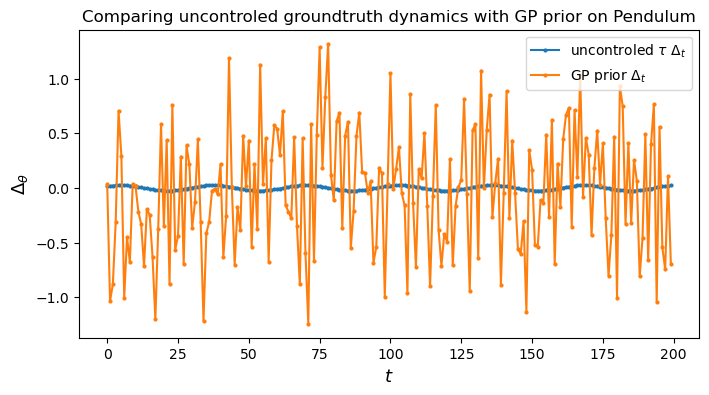

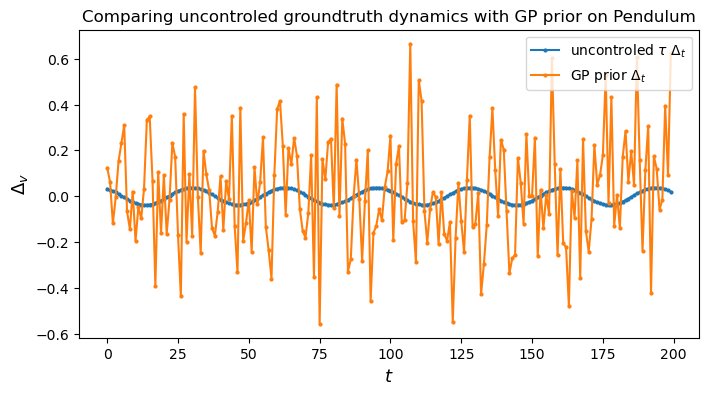

In [117]:
"""
dynamics: no control next observations theta & velocity
deltas: no control obs theta & velocity deltas
"""
seed = None
horizon = 200
time = np.arange(horizon)

plot_no_control('prior', [process_x, process_y], [r'\theta', 'v'], 'Pendulum')

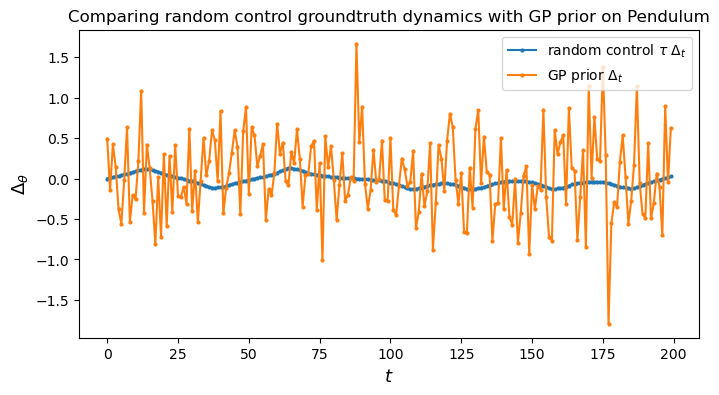

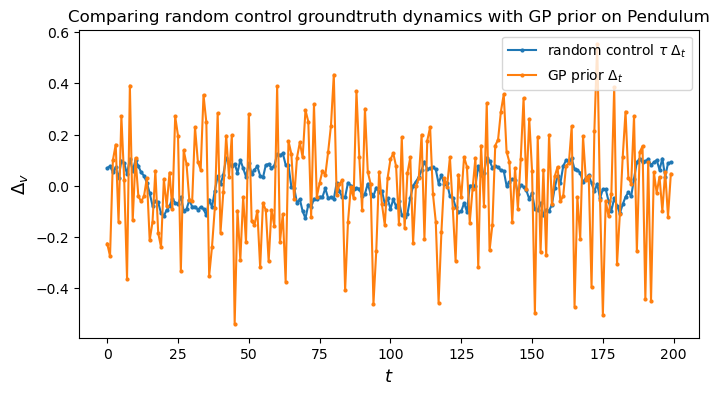

In [118]:
"""
r_dynamics: random control next observations theta & velocity
r_deltas: random control obs theta & velocity deltas
"""
seed = None
horizon = 200
time = np.arange(horizon)

plot_random_control('prior', [process_x, process_y], [r'\theta', 'v'], 'Pendulum')

### Posterior

In [119]:
display(process_x.model)

# x_test = np.array([init_cond])
# # x_test = process_x.data.x
# # x_test = np.array([[1., 0.5, 0.]])

# mu, cov = process_x.get_post_mu_cov(x_test)
# print(f"{mu=} {mu.shape=}\n")
# print(f"{cov=} {cov.shape=}\n")

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,False,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.2916
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[ 2.27 7.73 138.94]
GPR.likelihood.variance,Parameter,Softplus + Shift,,False,(),float64,0.00010000000000000011


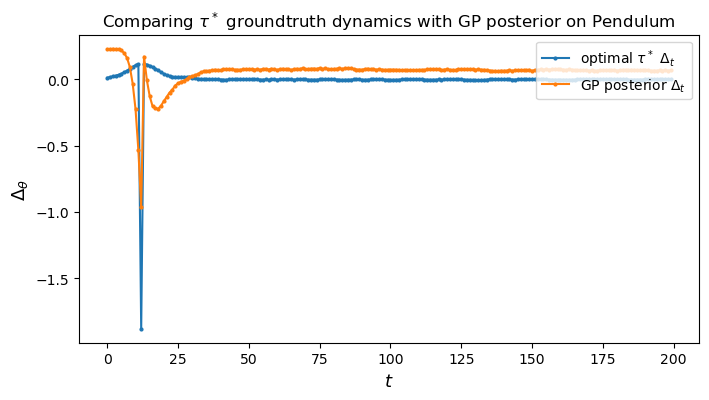

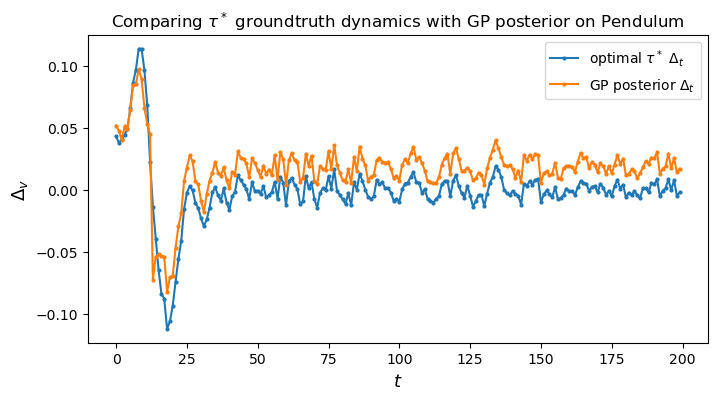

In [120]:
"""
dynamics: optimal control next observations theta & velocity
deltas: optimal control obs theta & velocity deltas
"""
x = optimal_t_pendulum['x*']

seed = None
horizon = 200
time = np.arange(horizon)

plot_optimal_t('posterior', [process_x, process_y], [r'\theta', 'v'], 'Pendulum')

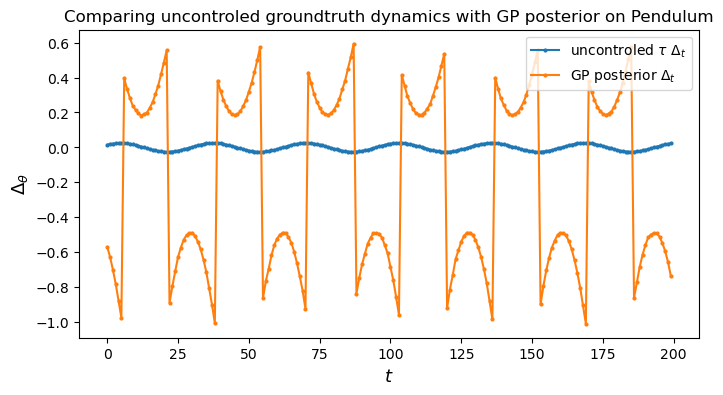

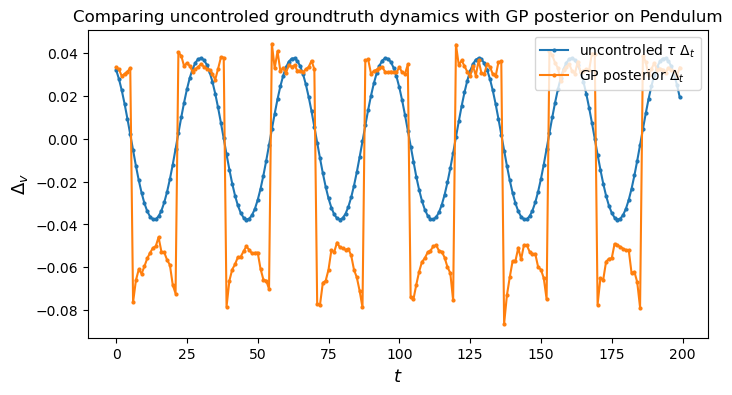

In [121]:
"""
dynamics: no control next observations theta & velocity
deltas: no control obs theta & velocity deltas
"""
seed = None
horizon = 200
time = np.arange(horizon)

plot_no_control('posterior', [process_x, process_y], [r'\theta', 'v'], 'Pendulum')

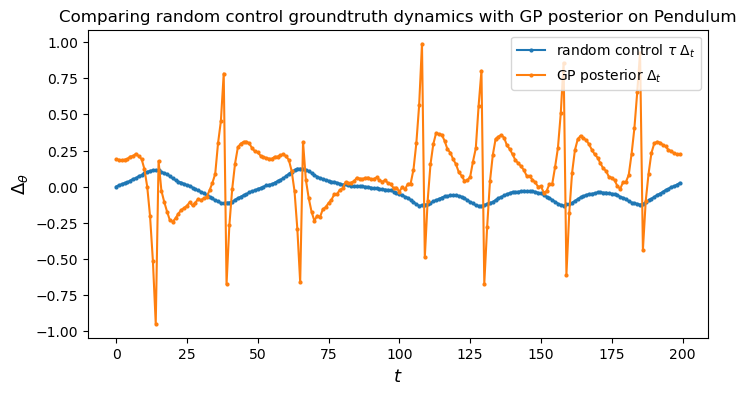

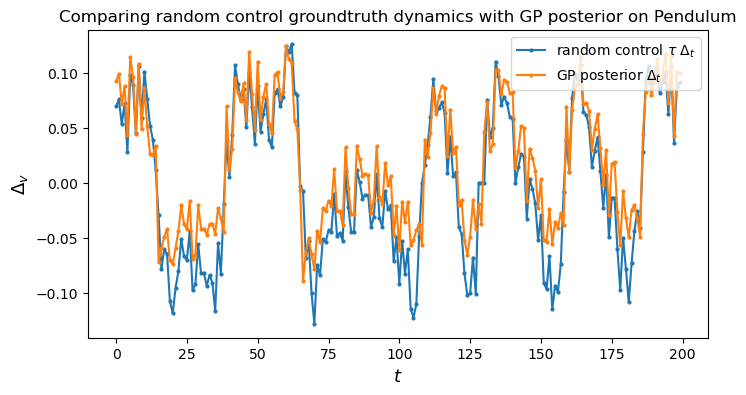

In [122]:
"""
r_dynamics: random control next observations theta & velocity
r_deltas: random control obs theta & velocity deltas
"""
seed = None
horizon = 200
time = np.arange(horizon)

plot_random_control('posterior', [process_x, process_y], [r'\theta', 'v'], 'Pendulum')

# END